# Neural Networks for MNIST dataset

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [3]:
train_ds = datasets.MNIST('data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                          ]))
test_ds = datasets.MNIST('data', train=False, download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))

In [4]:
batch_size = 32
# batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [5]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [6]:
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Looking are images

In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None:
        plt.title(title)

In [8]:
# first from torch to numpy
X = x.numpy()
Y = y.numpy()
X.shape

(32, 1, 28, 28)

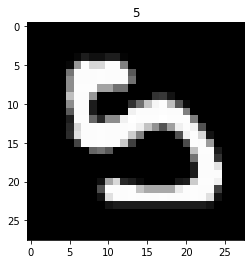

In [9]:
show(X[0][0], Y[0])

In [10]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [11]:
# for the number of neurons in the hidden unit
def get_model(M=300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net  # .cuda()

In [12]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    for epoch in range(num_epochs):
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            batch = images.shape[0]  # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28)  # .cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            total += batch
            sum_loss += batch * loss.item()

        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %
              (epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [13]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  # .cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss / total

In [14]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(8.56, 2.3117655239105224)

In [15]:
val_acc, val_loss, train_loss = train_model(
    train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.3546
Epoch [1/2], Valid Accuracy: 91.8400, Valid Loss: 0.3366
Epoch [2/2], Loss: 0.2736
Epoch [2/2], Valid Accuracy: 93.1200, Valid Loss: 0.2947


## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [16]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.01)

## Models with Dropout

In [17]:
def get_model_v2(M=300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules)  # .cuda()

In [18]:
net = get_model_v2(M=300, p=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [19]:
train_model(train_loader, test_loader, num_epochs=4,
            model=net, optimizer=optimizer)

Epoch [1/4], Loss: 0.4125
Epoch [1/4], Valid Accuracy: 92.8100, Valid Loss: 0.2640
Epoch [2/4], Loss: 0.2663
Epoch [2/4], Valid Accuracy: 93.8400, Valid Loss: 0.2821
Epoch [3/4], Loss: 0.2670
Epoch [3/4], Valid Accuracy: 93.6900, Valid Loss: 0.2482
Epoch [4/4], Loss: 0.2422
Epoch [4/4], Valid Accuracy: 93.9200, Valid Loss: 0.2932


(93.92, 0.29324834769908337, 0.24215630946553623)

## Exp 1: Learning Rate

In [23]:
lr = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

In [27]:
% % time
results = []
for learning_rate in lr:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    val_acc, val_loss, train_loss = train_model(
        train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results.append((learning_rate, val_acc, val_loss, train_loss))

Epoch [1/10], Loss: 49.2045
Epoch [1/10], Valid Accuracy: 11.3800, Valid Loss: 6.8345
Epoch [2/10], Loss: 3.5713
Epoch [2/10], Valid Accuracy: 10.3000, Valid Loss: 6.8140
Epoch [3/10], Loss: 2.4052
Epoch [3/10], Valid Accuracy: 9.8500, Valid Loss: 6.7849
Epoch [4/10], Loss: 2.4071
Epoch [4/10], Valid Accuracy: 10.1200, Valid Loss: 6.8661
Epoch [5/10], Loss: 2.4165
Epoch [5/10], Valid Accuracy: 10.3200, Valid Loss: 6.8339
Epoch [6/10], Loss: 2.4069
Epoch [6/10], Valid Accuracy: 9.8300, Valid Loss: 6.8034
Epoch [7/10], Loss: 2.4113
Epoch [7/10], Valid Accuracy: 11.3800, Valid Loss: 6.8712
Epoch [8/10], Loss: 2.4074
Epoch [8/10], Valid Accuracy: 11.3800, Valid Loss: 6.9607
Epoch [9/10], Loss: 2.4077
Epoch [9/10], Valid Accuracy: 9.8300, Valid Loss: 6.8618
Epoch [10/10], Loss: 2.4077
Epoch [10/10], Valid Accuracy: 10.1200, Valid Loss: 6.9777
Epoch [1/10], Loss: 2.3571
Epoch [1/10], Valid Accuracy: 27.3700, Valid Loss: 2.0225
Epoch [2/10], Loss: 2.2339
Epoch [2/10], Valid Accuracy: 11.3600,

In [30]:
results

[(1, 10.12, 6.977697636032104, 2.4077480761210124),
 (0.1, 9.8, 2.331640591049194, 2.3139865736643475),
 (0.01, 93.26, 0.3295981390826404, 0.218337464263166),
 (0.001, 97.78, 0.11555676937649113, 0.02127944609490769),
 (0.0001, 98.02, 0.06614703410156071, 0.0406049730475992),
 (1e-05, 93.83, 0.21990738485455513, 0.22792399299144744)]

### Interpolate between the best two values

In [20]:
lr2 = [0.0001, 0.0004, 0.0008, 0.001]

In [27]:
% % time
lr_results = []
for learning_rate in lr2:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    val_acc, val_loss, train_loss = train_model(
        train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    lr_results.append((learning_rate, val_acc, val_loss, train_loss))

Epoch [1/10], Loss: 0.4081
Epoch [1/10], Valid Accuracy: 93.0300, Valid Loss: 0.2319
Epoch [2/10], Loss: 0.1981
Epoch [2/10], Valid Accuracy: 95.4200, Valid Loss: 0.1619
Epoch [3/10], Loss: 0.1446
Epoch [3/10], Valid Accuracy: 96.2700, Valid Loss: 0.1294
Epoch [4/10], Loss: 0.1130
Epoch [4/10], Valid Accuracy: 96.8400, Valid Loss: 0.1104
Epoch [5/10], Loss: 0.0917
Epoch [5/10], Valid Accuracy: 97.1600, Valid Loss: 0.0946
Epoch [6/10], Loss: 0.0765
Epoch [6/10], Valid Accuracy: 97.3800, Valid Loss: 0.0877
Epoch [7/10], Loss: 0.0645
Epoch [7/10], Valid Accuracy: 97.5000, Valid Loss: 0.0801
Epoch [8/10], Loss: 0.0552
Epoch [8/10], Valid Accuracy: 97.8100, Valid Loss: 0.0740
Epoch [9/10], Loss: 0.0473
Epoch [9/10], Valid Accuracy: 97.7900, Valid Loss: 0.0696
Epoch [10/10], Loss: 0.0408
Epoch [10/10], Valid Accuracy: 97.8500, Valid Loss: 0.0660
Epoch [1/10], Loss: 0.2499
Epoch [1/10], Valid Accuracy: 96.3900, Valid Loss: 0.1263
Epoch [2/10], Loss: 0.1050
Epoch [2/10], Valid Accuracy: 97.400

In [28]:
lr_results

[(0.0001, 97.85, 0.06601504220291972, 0.040848820085047435),
 (0.0004, 97.65, 0.08438532228421536, 0.012245486892579356),
 (0.0008, 98.04, 0.08415286576391937, 0.015939184628241614),
 (0.001, 97.44, 0.12110307909450603, 0.01924213402531065)]

<li>By interpolation, the best parameter for learning rate is around 0.0001

## Exp2: Hidden Layer

In [26]:
results2 = []
layer_lst = [10, 50, 100, 300, 1000, 2000]
for M in layer_lst:
    net = get_model(M=M)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    val_acc, val_loss, train_loss = train_model(
        train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results2.append((M, val_acc, val_loss, train_loss))

Epoch [1/10], Loss: 0.5556
Epoch [1/10], Valid Accuracy: 87.3600, Valid Loss: 0.4353
Epoch [2/10], Loss: 0.4537
Epoch [2/10], Valid Accuracy: 86.8400, Valid Loss: 0.4658
Epoch [3/10], Loss: 0.4559
Epoch [3/10], Valid Accuracy: 86.6300, Valid Loss: 0.4590
Epoch [4/10], Loss: 0.4382
Epoch [4/10], Valid Accuracy: 86.3100, Valid Loss: 0.4687
Epoch [5/10], Loss: 0.4396
Epoch [5/10], Valid Accuracy: 88.4200, Valid Loss: 0.4115
Epoch [6/10], Loss: 0.4389
Epoch [6/10], Valid Accuracy: 89.4900, Valid Loss: 0.4020
Epoch [7/10], Loss: 0.4349
Epoch [7/10], Valid Accuracy: 89.2100, Valid Loss: 0.3953
Epoch [8/10], Loss: 0.4385
Epoch [8/10], Valid Accuracy: 88.6500, Valid Loss: 0.4208
Epoch [9/10], Loss: 0.4366
Epoch [9/10], Valid Accuracy: 88.4400, Valid Loss: 0.4209
Epoch [10/10], Loss: 0.4309
Epoch [10/10], Valid Accuracy: 88.9800, Valid Loss: 0.3934
Epoch [1/10], Loss: 0.3486
Epoch [1/10], Valid Accuracy: 92.0400, Valid Loss: 0.2860
Epoch [2/10], Loss: 0.2832
Epoch [2/10], Valid Accuracy: 92.870

In [34]:
results2

[(10, 88.98, 0.39337335471510887, 0.4308561109741529),
 (50, 93.06, 0.33597618907447907, 0.24314220560342073),
 (100, 93.57, 0.31975358169961254, 0.21447443515613365),
 (300, 94.79, 0.2859804305537924, 0.21395817924438354),
 (1000, 94.14, 0.37381741085213144, 0.21561581363447088),
 (2000, 94.1, 0.30223074814751744, 0.21539423916906428)]

<li>Yes, beacause we can see the since from the layer = 50, the validation loss reach 0.26 then flatuate to a bigger value in the 0.3 range. 

## Exp3: Weight Decay

In [28]:
% % time
results3 = []
w_lst = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
for w in w_lst:
    net = get_model(M=M)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=w)
    val_acc, val_loss, train_loss = train_model(
        train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    results3.append((w, val_acc, val_loss, train_loss))

Epoch [1/20], Loss: 0.1861
Epoch [1/20], Valid Accuracy: 96.5300, Valid Loss: 0.1177
Epoch [2/20], Loss: 0.0880
Epoch [2/20], Valid Accuracy: 97.0100, Valid Loss: 0.1026
Epoch [3/20], Loss: 0.0609
Epoch [3/20], Valid Accuracy: 96.9100, Valid Loss: 0.1075
Epoch [4/20], Loss: 0.0503
Epoch [4/20], Valid Accuracy: 97.6500, Valid Loss: 0.0930
Epoch [5/20], Loss: 0.0384
Epoch [5/20], Valid Accuracy: 97.6600, Valid Loss: 0.0989
Epoch [6/20], Loss: 0.0381
Epoch [6/20], Valid Accuracy: 98.0900, Valid Loss: 0.0828
Epoch [7/20], Loss: 0.0319
Epoch [7/20], Valid Accuracy: 97.5200, Valid Loss: 0.1147
Epoch [8/20], Loss: 0.0271
Epoch [8/20], Valid Accuracy: 97.2000, Valid Loss: 0.1396
Epoch [9/20], Loss: 0.0289
Epoch [9/20], Valid Accuracy: 97.9300, Valid Loss: 0.1245
Epoch [10/20], Loss: 0.0282
Epoch [10/20], Valid Accuracy: 97.6800, Valid Loss: 0.1244
Epoch [11/20], Loss: 0.0226
Epoch [11/20], Valid Accuracy: 97.8500, Valid Loss: 0.1500
Epoch [12/20], Loss: 0.0283
Epoch [12/20], Valid Accuracy: 98

Epoch [16/20], Valid Accuracy: 90.0300, Valid Loss: 0.4467
Epoch [17/20], Loss: 0.4646
Epoch [17/20], Valid Accuracy: 89.4900, Valid Loss: 0.4429
Epoch [18/20], Loss: 0.4644
Epoch [18/20], Valid Accuracy: 89.8100, Valid Loss: 0.4365
Epoch [19/20], Loss: 0.4646
Epoch [19/20], Valid Accuracy: 90.1400, Valid Loss: 0.4374
Epoch [20/20], Loss: 0.4649
Epoch [20/20], Valid Accuracy: 90.2200, Valid Loss: 0.4399
Epoch [1/20], Loss: 0.8976
Epoch [1/20], Valid Accuracy: 82.3900, Valid Loss: 0.8365
Epoch [2/20], Loss: 0.8418
Epoch [2/20], Valid Accuracy: 84.1000, Valid Loss: 0.8287
Epoch [3/20], Loss: 0.8304
Epoch [3/20], Valid Accuracy: 84.4500, Valid Loss: 0.8024
Epoch [4/20], Loss: 0.8256
Epoch [4/20], Valid Accuracy: 84.9100, Valid Loss: 0.7918
Epoch [5/20], Loss: 0.8213
Epoch [5/20], Valid Accuracy: 84.2700, Valid Loss: 0.8037
Epoch [6/20], Loss: 0.8202
Epoch [6/20], Valid Accuracy: 84.1500, Valid Loss: 0.7993
Epoch [7/20], Loss: 0.8213
Epoch [7/20], Valid Accuracy: 85.3700, Valid Loss: 0.791

In [35]:
results3

[(0, 98.04, 0.18974565684741357, 0.016121966866969383),
 (0.0001, 97.92, 0.10002850203365433, 0.030822503035720546),
 (0.001, 97.38, 0.08431064664162695, 0.06646437548243751),
 (0.01, 95.94, 0.14694650197178125, 0.16574470339119435),
 (0.1, 90.22, 0.43993339729309083, 0.4649301366488139),
 (0.3, 85.16, 0.7923685214042664, 0.8160987287521362)]

<li>We can see the regularized method reached better results compared with no regularized result.

##  Exp4: Drop Out

In [23]:
% % time
results4 = []
drop_lst = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
for p in drop_lst:
    net = get_model_v2(M=300, p=p)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    val_acc, val_loss, train_loss = train_model(
        train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    results4.append((p, val_acc, val_loss, train_loss))

Epoch [1/20], Loss: 0.1992
Epoch [1/20], Valid Accuracy: 97.1700, Valid Loss: 0.0997
Epoch [2/20], Loss: 0.0893
Epoch [2/20], Valid Accuracy: 96.9700, Valid Loss: 0.0968
Epoch [3/20], Loss: 0.0622
Epoch [3/20], Valid Accuracy: 97.7000, Valid Loss: 0.0763
Epoch [4/20], Loss: 0.0476
Epoch [4/20], Valid Accuracy: 97.5800, Valid Loss: 0.0834
Epoch [5/20], Loss: 0.0379
Epoch [5/20], Valid Accuracy: 97.4800, Valid Loss: 0.0880
Epoch [6/20], Loss: 0.0324
Epoch [6/20], Valid Accuracy: 97.7600, Valid Loss: 0.0819
Epoch [7/20], Loss: 0.0286
Epoch [7/20], Valid Accuracy: 98.0600, Valid Loss: 0.0777
Epoch [8/20], Loss: 0.0238
Epoch [8/20], Valid Accuracy: 97.4300, Valid Loss: 0.1093
Epoch [9/20], Loss: 0.0216
Epoch [9/20], Valid Accuracy: 97.9900, Valid Loss: 0.0846
Epoch [10/20], Loss: 0.0230
Epoch [10/20], Valid Accuracy: 97.8300, Valid Loss: 0.0973
Epoch [11/20], Loss: 0.0197
Epoch [11/20], Valid Accuracy: 97.9400, Valid Loss: 0.1069
Epoch [12/20], Loss: 0.0187
Epoch [12/20], Valid Accuracy: 98

Epoch [16/20], Valid Accuracy: 97.8000, Valid Loss: 0.1318
Epoch [17/20], Loss: 0.0146
Epoch [17/20], Valid Accuracy: 97.9000, Valid Loss: 0.1473
Epoch [18/20], Loss: 0.0151
Epoch [18/20], Valid Accuracy: 98.1200, Valid Loss: 0.1321
Epoch [19/20], Loss: 0.0130
Epoch [19/20], Valid Accuracy: 97.9500, Valid Loss: 0.1382
Epoch [20/20], Loss: 0.0109
Epoch [20/20], Valid Accuracy: 98.2000, Valid Loss: 0.1326
Epoch [1/20], Loss: 0.8855
Epoch [1/20], Valid Accuracy: 92.4300, Valid Loss: 0.2723
Epoch [2/20], Loss: 0.1635
Epoch [2/20], Valid Accuracy: 96.7400, Valid Loss: 0.1110
Epoch [3/20], Loss: 0.0909
Epoch [3/20], Valid Accuracy: 97.0700, Valid Loss: 0.0930
Epoch [4/20], Loss: 0.0666
Epoch [4/20], Valid Accuracy: 97.7900, Valid Loss: 0.0747
Epoch [5/20], Loss: 0.0511
Epoch [5/20], Valid Accuracy: 97.6500, Valid Loss: 0.0762
Epoch [6/20], Loss: 0.0406
Epoch [6/20], Valid Accuracy: 97.5800, Valid Loss: 0.0905
Epoch [7/20], Loss: 0.0340
Epoch [7/20], Valid Accuracy: 97.6000, Valid Loss: 0.086

In [26]:
results4

[(0, 98.05, 0.136631362753248, 0.014576189118806133),
 (0.1, 98.09, 0.1452093840407403, 0.014103234035028193),
 (0.3, 98.01, 0.15555740666334553, 0.00915450853975066),
 (0.5, 97.87, 0.1439852170264713, 0.013332274961422474),
 (0.7, 98.2, 0.13264456106708913, 0.010947683862093624),
 (0.9, 97.71, 0.1549760639046227, 0.012923106805318175)]

<li>The best performance is achieved when the dropout ratio equals 0.7. 
<li>Why Dropout method work: Because the outputs of a layer under dropout are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training.
<li>The Dropout method work generally performs better than a model without in terms of validation accuracy. 
<li>Drop out method performs slightly worse than L2 regularization but it cost only 25% of the time the regularization method is needed.